# Advanced Data Analytics for Management Support - Assignment Submission

## Table of Contents

    1. Introduction
    2. Data Loading and Cleaning
    3. Feature Analysis 
        3.1 Target Distribution
        3.2 Date features
    4. Model Selection
        4.1 Data Preparation
        4.2 Models(structured data)
            4.2.1 Linear Regression
            4.2.2 Random Forest
            4.2.3 XGBoost
            4.2.4 Adaboost Regressor
            4.2.4 FNN
        4.3 RNN Architecture (unstructured data)
            4.3.1 GRU
            4.3.2 LSTM
            4.3.3 Bidirectional LSTM
            4.3.4 CNN-LSTM
        4.4 Full Model Architecture
    5. Application to Test Set
    6. Conclusion


## 1. Introduction

The task of this assignment is to predict the price of propertied hosted on an online marketplace for accommodation rental called as Airbnb, based on different webscraped features like the location, number of rooms, property type, texts with the listing description, and rental price per night.The main focus hereby lies on building an NN-based model that predicts the price of listings in the unseen dataset based on both text and tabular data.

In the following, we analyze the train and test data, alter some of the features, as well as create new ones. Afterwards, different modeling approaches are considered and an NLP pipeline is chosen which is then applied to our test data.

In [5]:
!pip install textstat

In [6]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import re
import datetime
import time
import textstat
from bs4 import BeautifulSoup
from collections import Counter
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.keras import activations, losses
from keras.callbacks import EarlyStopping
import xgboost as xgb
from bs4 import BeautifulSoup
import emoji as emot
import nltk  
nltk.download('omw-1.4')
# When running this notebook for the first time, you have to download some NLTK packages. To do so, simply uncomment the next lines
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV ,cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

import tensorflow as tf
import pickle
import string
import statistics
import math
import warnings

warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 2. Data Loading and Cleaning 

To make the code modular, data cleaning and feature engineering for tabular data and unstructured data has been done in a separate notebooks (see Data_cleaning_tabular.ipnyb and Data_cleaning_text.ipnyb).

The following steps are performed for cleaning and feature engineering of tabular data:

1. Checking and handling the data for null values 
2. Checking for duplicated values in the dataset
3. Handling categorical and nominal variables( consists of creating dummy variables, binning via weight of evidence encoding, and scaling the continous variables)
4. Creating new features(features related to date and time are utilized to generate new features appropriate for modeling)
5. Feature Selection to find the best combination of features based on the statistical performance

The cleaned tabular data is then stored in the pickle file, which can then further be used to perform text cleaning. 

The following steps are performed in text cleaning:

1. Removing whitespace (tabs, newlines).Newline indicators are removed ("\n" and "\xa0")
2. remove the punctuation, upper casing and words that include non-alphanumeric characters.
3. Stopwords are filtered out
4. html content is removed for a more sophisticated cleaning of text
5. The words are lemmatized

We would be using pickle file containing the pre-processed tabular (numerical) data for further text pre-processing and modeling tasks in this notebook.

The cleaned numerical features for both data sets are loaded in the following manner:

In [7]:
train = pd.read_pickle('../input/airbnb-last-version-numerical-data/x_train.pkl')
test = pd.read_pickle('../input/airbnb-last-version-numerical-data/x_test.pkl')

In [8]:
test.isnull().sum()/55284 * 100

host_is_superhost                         0.000000
reviews_per_month                         0.000000
room_type_Private room                    0.000000
bed_type_Real Bed                         0.000000
bed_type_Pull-out Sofa                    0.000000
bedrooms                                  0.000000
bed_type_Couch                            0.000000
beds                                      0.000000
room_type_Shared room                     0.000000
review_scores_location                    0.000000
guests_included                           0.000000
bed_type_Futon                            0.000000
review_scores_rating                      0.000000
house_rules                              22.755228
summary                                   2.852543
host_identity_verified                    0.000000
host_has_profile_pic                      0.000000
review_scores_accuracy                    0.000000
host_response_time_within a day           0.000000
space                          

In [9]:
test['property_type_woe'].fillna(0,inplace=True)

These cleaned train and test datasets obtained after tabular data preprocessing(see "Data_cleaning_tabular.ipnyb") are further processed for text cleaning as seen in the following section, "Data Cleaning(unstructured data)".

### 2.1 Data Cleaning(Unstructured Data)

In [16]:
def remove_whitespace(text):
    """ Function to remove whitespace (tabs, newlines). """
    return ' '.join(text.split())

In [ ]:
def convert_emoticons(text):
    """ Function to convert emoticons into a text that reflects their meaning. """
    EMOTICONS = emot.EMOTICONS()
    for i in EMOTICONS:
        text = text.replace(i, EMOTICONS[i])
    return text

In [4]:
def remove_punctuation_and_casing(text):
    """
    Function to remove the punctuation, upper casing and words that include
    non-alphanumeric characters.
    """
    chars = '!\"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
    text = text.translate(str.maketrans(chars, ' ' * len(chars)))
    return ' '.join([word.lower() for word in text.split() if word.isalpha()])

In [5]:
from nltk.corpus import stopwords

english_stopwords = stopwords.words('english')

In [6]:
def remove_stopwords(text):
    """ Function to remove stopwords. """
    return ' '.join([word for word in str(text).split() if word not in english_stopwords])

In [8]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Helper function that calls the POS tagger for an input word and return a code that can be used for lemmatization"""
    # Extract the first letter of the POS tag (see the above example to understand the output coming from pos_tag)
    tag = nltk.pos_tag([word])[0][1][0].upper()  
    # Dictionary to map these letters to wordnet codes that the lemmatizer understands
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text, **kwargs):
    """ Function to lemmatize words. """
    return ' '.join([lemmatizer.lemmatize(word, **kwargs) for word in text.split()])

In [10]:
def text_cleaning(documents):
    """
    Function for standard NLP pre-processing including removal of html tags,
    whitespaces, non-alphanumeric characters, and stopwords. Emoticons are
    converted to text that reflects their meaning. Words are subject to
    lemmatization using their POS tags.
    """
    cleaned_text = []  # our output will be a list of documents
    lemmatizer = WordNetLemmatizer()
    
    print('Processing input array with {} elements...'.format(documents.shape[0]))
    counter = 0
    
    for doc in documents:
        text = BeautifulSoup(doc).get_text() # remove html content
        text = remove_whitespace(text) # remove whitespaces
        text = remove_punctuation_and_casing(text) # remove punctuation and casing
        text = remove_stopwords(text) # remove stopwords
        text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]) # lemmatize each word
        
        cleaned_text.append(text)

        if (counter > 0 and counter % 50 == 0):
            print('Processed {} documents'.format(counter))
            
        counter += 1
        
    return cleaned_text

In [18]:
train['neighborhood_overview'].fillna('',inplace=True)
train['space'].fillna('',inplace=True)
train['summary'].fillna('',inplace=True)
train['name'].fillna('',inplace=True)
train['transit'].fillna('',inplace=True)
train['house_rules'].fillna('',inplace=True)
train['amenities'].fillna('',inplace=True)

In [ ]:
train['name'] = text_cleaning(train['name'])
train['summary'] = text_cleaning(train['summary'])
train['space'] = text_cleaning(train['space'])
#train['description'] = text_cleaning(train['description'])
train['experiences_offered'] = text_cleaning(train['experiences_offered'])
train['neighborhood_overview'] = text_cleaning(train['neighborhood_overview'])
train['transit'] = text_cleaning(train['transit'])
train['house_rules'] = text_cleaning(train['house_rules'])
train['amenities'] = text_cleaning(train['amenities'])

In [22]:
test['neighborhood_overview'].fillna('',inplace=True)
test['space'].fillna('',inplace=True)
test['summary'].fillna('',inplace=True)
test['name'].fillna('',inplace=True)
test['transit'].fillna('',inplace=True)
test['house_rules'].fillna('',inplace=True)
test['amenities'].fillna('',inplace=True)

In [ ]:
test['name'] = text_cleaning(test.name)
test['summary'] = text_cleaning(test.summary)
test['space'] = text_cleaning(test.space)
#train['description'] = text_cleaning(train['description'])
test['experiences_offered'] = text_cleaning(test.experiences_offered)
test['neighborhood_overview'] = text_cleaning(test.neighborhood_overview)
test['transit'] = text_cleaning(test.transit)
test['house_rules'] = text_cleaning(test.house_rules)
test['amenities'] = text_cleaning(test.amenities)

In [24]:
train.to_pickle('x_train_text_for_pre_trained_word_emb.pkl')
test.to_pickle('x_test_text_for_pre_trained_word_emb.pkl')

Saving the cleaned train and test data (both tabular and unstructured features) in a pickle to avoid re-running the cleaning pipeline again.

In [10]:
train = pd.read_pickle('../input/final-text-cleaned/x_train_text_for_pre_trained_word_emb.pkl')
test = pd.read_pickle('../input/final-text-cleaned/x_test_text_for_pre_trained_word_emb.pkl')

In [69]:
# Loop through the words and update a counter keeping track of word counts
import collections

word_counter = collections.Counter()
for r in train["neighborhood_overview"]:
    for w in r.split():        
        word_counter.update({w: 1})  

In [70]:
# Query the top most frequent words
top_n = 10
word_counter.most_common(top_n)

[('walk', 32816),
 ('london', 27948),
 ('restaurant', 22357),
 ('minute', 21971),
 ('park', 20956),
 ('area', 17560),
 ('shop', 16559),
 ('street', 16379),
 ('away', 13269),
 ('market', 12593)]

# 3. Feature Analysis

## 3.1 Target Distribution

Here we use the original(uncleaned train and test) datasets for feature analysis purpose.

In [103]:
train_orig = pd.read_csv("../input/airbnb/train.csv", sep=",", encoding="utf-8")
test_orig = pd.read_csv("../input/airbnb/test.csv", sep=",", encoding="utf-8")

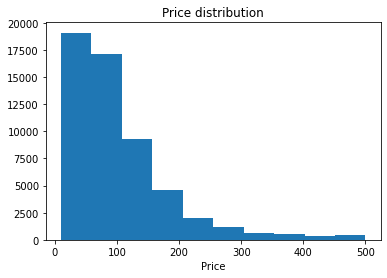

In [97]:
# Show target distribution
plt.hist(train.price)
plt.xlabel('Price')
plt.title('Price distribution')
plt.show();

The price of the properties are mostly towards the lower side, with only a few properties with high prices. These high prices cannot be treated as outliers since there might exist valid reasons for these high prices. 

## 3.2 Date Feature

In [105]:
train_orig["host_since"] = train_orig["host_since"].astype("datetime64[ns]")
train_orig["host_since"].fillna(pd.to_datetime('2015-05-21'),inplace = True)
train_orig['host_days'] = (datetime.datetime.today() - train_orig['host_since'])//np.timedelta64(1,'D')   
train_orig['host_days'] = train_orig['host_days']/365

In [108]:
train_orig['year'] = pd.DatetimeIndex(train_orig['host_since']).year
train_orig['month'] = pd.DatetimeIndex(train_orig['host_since']).month

In [111]:
test_orig['year'] = pd.DatetimeIndex(test_orig['host_since']).year
test_orig['month'] = pd.DatetimeIndex(test_orig['host_since']).month

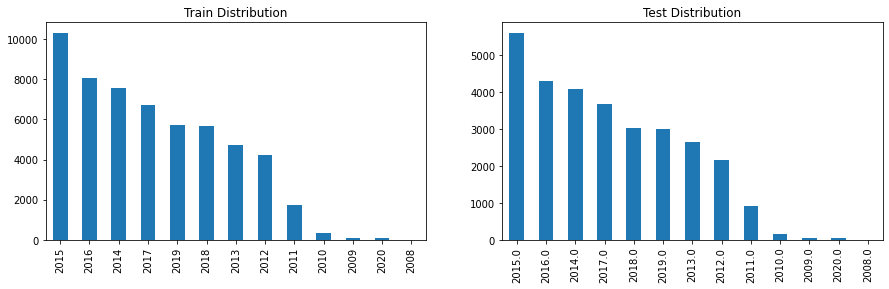

In [112]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Train Distribution")
pd.Series(train_orig.year.value_counts()).plot.bar();
plt.subplot(1, 2, 2)
plt.title("Test Distribution")
pd.Series(test_orig.year.value_counts()).plot.bar();

It is seen that most of the properties have been listed on airbnb in the year 2015 and almost none in 2008. 

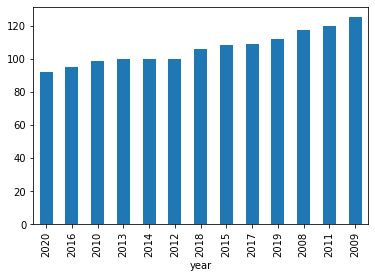

In [114]:
train_orig.groupby("year")["price"].agg("mean").sort_values().plot.bar();

This shows that as the time passed the prices of the properties being listed on Airbnb decreased. This feature seems like a strong predictor in further analysis.

# 4. Model Selection

## 4.1 Data preparation using Pre-trained word embeddings

Before we proceed with benchmarking and modeling, we need to make sure that our text features are in appropriate format to be fed into NLP algorithms. The first question that pops up when dealing with Deep Learning models is whether to work with pre-trained word embeddings or embedding layer like TextVectorization using keras. Similar to most problems in AI, there might not be a universally correct answer to this question that works in every scenario. Therefore, we perform experimentation based on these two types of embeddings to study their effects on the performance of the NLP models. 

In order to make the code modular we create two modeling notebooks:
1. w2v_pretrained_modeling_airbnb.ipynb
2. Self_trained_emb_modeling_airbnb.ipynb

w2v_pretrained_modeling_airbnb.ipynb i.e. the current notebook covers the modeling the data using pre-trained word embeddings. Additionally, we need to load our pre-trained embeddings and make some changes to the text to be able to unlock their full potential.

For our embeddings, we decide to go with 100-dimensional wiki2vec embeddings from https://wikipedia2vec.github.io/wikipedia2vec/pretrained/

Looking at the "description" feature we can see that it is a combination of summary,space and neighborhood_overview text features. In order to avoid redundant information in the pipeline, we chose to drop the description feature from the analysis. Also, since "description" feature is relatively long as compared to summary,space and neighborhood_overview features, the context might get lost in dense layers of the NLP models. 

In [11]:
import datetime
import time

In [12]:
# Load wiki2vec embeddings:
start = time.time()
wiki2vec = KeyedVectors.load_word2vec_format('../input/enwiki-100/enwiki_20180420_100d.txt')
end = time.time()
print(f"Loaded wiki2vec embeddings in {end - start} seconds.")

Loaded wiki2vec embeddings in 304.7469847202301 seconds.


In [8]:
wiki2vec.most_similar("walk")

[('walking', 0.7974323034286499),
 ('walks', 0.7364681363105774),
 ('stroll', 0.7279573082923889),
 ('walked', 0.7097617387771606),
 ('go', 0.6963003873825073),
 ('ride', 0.6943541169166565),
 ('traipse', 0.6928747892379761),
 ('fillingfir', 0.6851910948753357),
 ('wander', 0.6751559376716614),
 ('fireroad', 0.674683690071106)]

Splitting the training data into train and validation sets for analyzing the performance of different NLP models.

In [13]:
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(train.drop("price",axis = 1), train['price'], test_size=0.20, random_state=111)

In [14]:
X_train_nlp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44227 entries, 45478 to 12116
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   host_is_superhost                      44227 non-null  float64       
 1   reviews_per_month                      44227 non-null  float64       
 2   room_type_Private room                 44227 non-null  uint8         
 3   bed_type_Real Bed                      44227 non-null  uint8         
 4   bed_type_Pull-out Sofa                 44227 non-null  uint8         
 5   bedrooms                               44227 non-null  float64       
 6   bed_type_Couch                         44227 non-null  uint8         
 7   beds                                   44227 non-null  float64       
 8   room_type_Shared room                  44227 non-null  uint8         
 9   review_scores_location                 44227 non-null  fl

Tokenized objects and embedding matrices are initialized separately for each text feature. To truncate the text features optimally we determine the length of the tokens for different percentiles. Furthermore, we pick the maximum length which falls under the 99.7 percentile for all the text columns. This allows us to use text features mostly without truncation. Additonally,this makes the length optimal by reducing the amount of padding needed for the text features.

In [15]:
sumamry = np.array(list(map(lambda x:len(x.split()), X_train_nlp['name'].tolist())))
print("name",np.percentile(sumamry,[25,50,75,90,99.7],))

sumamry = np.array(list(map(lambda x:len(x.split()), X_train_nlp['summary'].tolist())))
print("summary",np.percentile(sumamry,[25,50,75,90,99.7],))

sumamry = np.array(list(map(lambda x:len(x.split()), X_train_nlp['space'].tolist())))
print("space",np.percentile(sumamry,[25,50,75,90,99.7],))

sumamry = np.array(list(map(lambda x:len(x.split()), X_train_nlp['neighborhood_overview'].tolist())))
print("neighborhood_overview",np.percentile(sumamry,[25,50,75,90,99.7],))

sumamry = np.array(list(map(lambda x:len(x.split()), X_train_nlp['transit'].tolist())))
print("transit",np.percentile(sumamry,[25,50,75,90,99.7],))

sumamry = np.array(list(map(lambda x:len(x.split()), X_train_nlp['house_rules'].tolist())))
print("house_rules",np.percentile(sumamry,[25,50,75,90,99.7],))

sumamry = np.array(list(map(lambda x:len(x.split()), X_train_nlp['amenities'].tolist())))
print("amenities",np.percentile(sumamry,[25,50,75,90,99.7],))

name [4. 5. 6. 7. 8.]
summary [ 23.  35.  47.  52. 101.]
space [  0.  21.  57.  96. 116.]
neighborhood_overview [  0.  16.  42.  82. 109.]
transit [  0.  14.  32.  56. 109.]
house_rules [ 0.  3. 17. 44. 98.]
amenities [21. 31. 45. 58. 99.]


In [16]:
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

def get_embedding_matrix(tokenizer, pretrain, vocab_size):
    '''
        Helper function to construct an embedding matrix for
        the focal corpus based on some pre-trained embeddings.
    '''

    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))

    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # There will be some words in our corpus for which we lack a pre-trained embedding.
    # In this tutorial, we will simply use a vector of zeros for such words. We also keep
    # track of the words to do some debugging if needed
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. This is crucial to ensure
    # that the position of a words in our embedding matrix corresponds to its index in our integer
    # encoded input data
    for word, i in tokenizer.word_index.items():
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return emb_mat, oov_words

In [18]:
def tokenizer(train_text,test_text,max_length):
    tokenizer_text = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
    tokenizer_text.fit_on_texts(train_text)
    NUM_WORDS_TEXT = len(tokenizer_text.word_index) + 1
    x_train = tokenizer_text.texts_to_sequences(train_text)
    MAX_TEXT_LENGTH = max_length
    x_train_pad = pad_sequences(x_train, MAX_TEXT_LENGTH)
    #encode and pad test data
    x_test = tokenizer_text.texts_to_sequences(test_text)
    x_test_pad = pad_sequences(x_test, MAX_TEXT_LENGTH)
    wiki_weights, _ = get_embedding_matrix(tokenizer_text, wiki2vec, NUM_WORDS_TEXT)
    return x_train_pad,x_test_pad,wiki_weights,NUM_WORDS_TEXT   

Below we create tokenizer objects and embedding matrices for training the model on our train dataset and analyzing the performace of different models for our the training data.

In [19]:
X_tr_name,X_test_name,wiki_weights_name,NUM_WORDS_NAME = tokenizer(X_train_nlp.name,X_test_nlp.name,8)
X_tr_summary,X_test_summary,wiki_weights_summary,NUM_WORDS_SUMMARY = tokenizer(X_train_nlp.summary,X_test_nlp.summary,101)
X_tr_space,X_test_space,wiki_weights_space,NUM_WORDS_SPACE = tokenizer(X_train_nlp.space,X_test_nlp.space,116)
#X_tr_experiences,X_test_experiences,wiki_weights_experiences = tokenizer(X_train_nlp.experiences_offered,X_test_nlp.experiences_offered,692)
X_tr_ngbr,X_test_ngbr,wiki_weights_ngbr,NUM_WORDS_NGBR = tokenizer(X_train_nlp.neighborhood_overview,X_test_nlp.neighborhood_overview,109)
X_tr_transit,X_test_transit,wiki_weights_transit,NUM_WORDS_TRANSIT = tokenizer(X_train_nlp.transit,X_test_nlp.transit,109)
X_tr_hr,X_test_hr,wiki_weights_hr,NUM_WORDS_HR = tokenizer(X_train_nlp.house_rules,X_test_nlp.house_rules,98)
X_tr_amenities,X_test_amenities,wiki_weights_amenities,NUM_WORDS_AMENITIES = tokenizer(X_train_nlp.amenities,X_test_nlp.amenities,99)

Created embedding matrix of shape (5410, 100)
Encountered 849 out-of-vocabulary words.
Created embedding matrix of shape (16410, 100)
Encountered 3030 out-of-vocabulary words.
Created embedding matrix of shape (17044, 100)
Encountered 2480 out-of-vocabulary words.
Created embedding matrix of shape (17938, 100)
Encountered 2344 out-of-vocabulary words.
Created embedding matrix of shape (10104, 100)
Encountered 1594 out-of-vocabulary words.
Created embedding matrix of shape (8527, 100)
Encountered 951 out-of-vocabulary words.
Created embedding matrix of shape (269, 100)
Encountered 0 out-of-vocabulary words.


In order to train our full model arcitecture we reinitialize the the tokenizer objects and embedding matrices for the unseen data using our whole train dataset as seen below. 

In [92]:
tr_name,test_name,wiki_weights_name_tr,NUM_WORDS_NAME_tr = tokenizer(train.name,test.name,8)
tr_summary,test_summary,wiki_weights_summary_tr,NUM_WORDS_SUMMARY_tr = tokenizer(train.summary,test.summary,101)
tr_space,test_space,wiki_weights_space_tr,NUM_WORDS_SPACE_tr = tokenizer(train.space,test.space,116)
#X_tr_experiences,X_test_experiences,wiki_weights_experiences = tokenizer(X_train_nlp.experiences_offered,X_test_nlp.experiences_offered,692)
tr_ngbr,test_ngbr,wiki_weights_ngbr_tr,NUM_WORDS_NGBR_tr = tokenizer(train.neighborhood_overview,test.neighborhood_overview,109)
tr_transit,test_transit,wiki_weights_transit_tr,NUM_WORDS_TRANSIT_tr = tokenizer(train.transit,test.transit,109)
tr_hr,test_hr,wiki_weights_hr_tr,NUM_WORDS_HR_tr = tokenizer(train.house_rules,test.house_rules,98)
tr_amenities,test_amenities,wiki_weights_amenities_tr,NUM_WORDS_AMENITIES_tr = tokenizer(train.amenities,test.amenities,99)

Created embedding matrix of shape (6019, 100)
Encountered 1023 out-of-vocabulary words.
Created embedding matrix of shape (18327, 100)
Encountered 3772 out-of-vocabulary words.
Created embedding matrix of shape (18747, 100)
Encountered 2990 out-of-vocabulary words.
Created embedding matrix of shape (19596, 100)
Encountered 2775 out-of-vocabulary words.
Created embedding matrix of shape (11030, 100)
Encountered 1860 out-of-vocabulary words.
Created embedding matrix of shape (9293, 100)
Encountered 1113 out-of-vocabulary words.
Created embedding matrix of shape (271, 100)
Encountered 0 out-of-vocabulary words.


## 4.2 Models(structured data)

In [21]:
x_train_num_cols = X_train_nlp.select_dtypes(exclude=["category","datetime64[ns]","object"])
x_val_num_cols = X_test_nlp.select_dtypes(exclude=["category","datetime64[ns]","object"])

### 4.2.1 Linear Regression

In [80]:
regression = LinearRegression(normalize=True)
regression.fit(x_train_num_cols, y_train_nlp)

prediction = regression.predict(x_val_num_cols)

print(f"R2: {regression.score(x_val_num_cols, y_test_nlp)}")
print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

R2: 0.5270095346909986
MSE: 3197.702435741736
MAE: 35.790265794959716


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


This is already a very nice result from Linear regression which can serve as a benchmark performance for the other models for tabular and text data.

### 4.2.2 Random Forest

In order to determine the best hyperparamaters for the ensemble methods we apply the HalvingGridSearchCV algorithm to fine tune the models. This will also help in validating the performance of the model.

In [119]:
rf = RandomForestRegressor()

param_grid = {'n_estimators': [500,1000],
              'max_samples' : [0.1,0.5]              
             }

search = HalvingGridSearchCV(rf, param_grid,
                            random_state=0, cv=5, scoring='neg_root_mean_squared_error').fit(x_train_num_cols, y_train_nlp)
search.best_params_  
#{'max_samples': 0.5, 'n_estimators': 500}

{'max_samples': 0.5, 'n_estimators': 500}

In [120]:
rf = RandomForestRegressor(n_estimators=500, max_depth = None, max_samples = 0.5, random_state=111, verbose=0, n_jobs=10)
rf.fit(x_train_num_cols, y_train_nlp)

prediction = rf.predict(x_val_num_cols)

print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 2499.7121170632586
MAE: 30.639093778865416


As expected, Random forest regressor outperforms the linear regression model.

### 4.2.3 XGB Boost

In [82]:
import xgboost as xgb

In [121]:
xgb_regress = xgb.XGBRegressor()

param_grid = {'n_estimators': [500,1000],
              'learning_rate' : [0.1,0.05]              
             }

search = HalvingGridSearchCV(xgb_regress, param_grid,
                            random_state=0, cv=5, scoring='neg_root_mean_squared_error').fit(x_train_num_cols, y_train_nlp)
search.best_params_  
#{'max_samples': 0.05, 'n_estimators': 1000}

{'learning_rate': 0.05, 'n_estimators': 1000}

In [83]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.05,
                max_depth=2, alpha=20, n_estimators = 1000)
xg_reg.fit(x_train_num_cols,y_train_nlp)

prediction = xg_reg.predict(x_val_num_cols)

print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 2712.630927912829
MAE: 31.980587851104183


XGB Boost does outperform the Linear regression but fails to surpass the random forest regressor, potentially because of overfitting issue.

### 4.2.4 AdaBoost Regressor

In [122]:
adaregress = AdaBoostRegressor()

param_grid = {'n_estimators': [500,1000],
              'learning_rate' : [0.1,0.5,1.0]              
             }

search = HalvingGridSearchCV(adaregress, param_grid,
                            random_state=0, cv=5, scoring='neg_root_mean_squared_error').fit(x_train_num_cols, y_train_nlp)
search.best_params_  
#{'max_samples': 0.1, 'n_estimators': 1000}

{'learning_rate': 0.1, 'n_estimators': 1000}

In [86]:
ada_reg = AdaBoostRegressor(learning_rate = 0.1,n_estimators = 1000,random_state=0)
ada_reg.fit(x_train_num_cols,y_train_nlp)

prediction = ada_reg.predict(x_val_num_cols)

print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 5249.059538733441
MAE: 59.882034305683106


Suprisingly Adacost Regressor performs worst among all the ensemble and linear regression model. This might be because the price is skewed towards lower values,which indicates inability of adacost regressor to predict very high values in this case.

### 4.2.5 FNN

In [22]:
input_numeric = tf.keras.Input(shape=(x_train_num_cols.shape[1],), dtype=tf.float64, name="numeric")
output_numeric = layers.Dense(128, activation='relu')(input_numeric)
output_numeric = layers.Dense(64, activation='relu')(output_numeric)
#output_numeric = layers.Dropout(0.2)(output_numeric)
output_numeric = layers.Dense(32, activation="relu")(output_numeric)
output = layers.Dense(1, activation="linear")(output_numeric)


## Finalize the model with input and output flow
model = tf.keras.Model(inputs = [
                                input_numeric
                                ], 
                            outputs = output)
print(model.summary())
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=losses.LogCosh(), metrics=['mae'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, verbose=0, patience=3, restore_best_weights=True)

history = model.fit(
    [x_train_num_cols],
    y_train_nlp,
    validation_split=0.2,
    epochs = 40,
    batch_size = 64,
    callbacks=[earlystopping],
    verbose =1)

2022-09-09 21:20:24.055087: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
numeric (InputLayer)         [(None, 33)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               4352      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________
None


2022-09-09 21:20:24.313054: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
553/553 [==============================] - 2s 3ms/step - loss: 82.0097 - mae: 82.6994 - val_loss: 48.9585 - val_mae: 49.6448
Epoch 2/40
553/553 [==============================] - 2s 3ms/step - loss: 41.2559 - mae: 41.9405 - val_loss: 37.0922 - val_mae: 37.7753
Epoch 3/40
553/553 [==============================] - 2s 3ms/step - loss: 35.6199 - mae: 36.3025 - val_loss: 34.2955 - val_mae: 34.9767
Epoch 4/40
553/553 [==============================] - 1s 3ms/step - loss: 33.8786 - mae: 34.5597 - val_loss: 33.1315 - val_mae: 33.8121
Epoch 5/40
553/553 [==============================] - 1s 3ms/step - loss: 33.0331 - mae: 33.7139 - val_loss: 32.6102 - val_mae: 33.2911
Epoch 6/40
553/553 [==============================] - 1s 3ms/step - loss: 32.5502 - mae: 33.2303 - val_loss: 32.1905 - val_mae: 32.8710
Epoch 7/40
553/553 [==============================] - 1s 3ms/step - loss: 32.2599 - mae: 32.9399 - val_loss: 31.9016 - val_mae: 32.5821
Epoch 8/40
553/553 [============================

In [88]:
prediction = model.predict([x_val_num_cols])
print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 3002.6311047996437
MAE: 31.25935934421608


The performance of the Feed Forward neural network on the tabular data also crosses the benchmark set by the linear regression model. FNNs performance is comparable to both random forest and XGB boost in our case. Although, it doesn't seem to win the benchmark performance for tabular data.

Both MSE and MAE-wise it looks like the Random Forest regressor is winning the benchmark. This gives us a baseline of what to expect from the NLP models. 

## 4.3 RNN Architecture (unstructured data)

Since there are so many possibilities for an NLP model, we limit ourselves to trying 4 different model configurations on the text features. For all of them, we decide on some kind of LSTM architecture with embedding layer using Textvectorization.
The Keras Sequential API allows us to effectively train text feature models.

1. Basic GRU
2. LSTM
3. CNN-LSTM
4. Bidirectional LSTM

For all of these models, different hyperparameter configurations were tested. The number of hidden units inside the GRU units does not seem to make a big difference, so they are left at 128 for all the other models. The final activation functions are set to ReLU, since price of peroperties are never negative.

We refrain from using mean squared error loss, since it would make training performance difficult to judge.
Instead, we could use the mean absolute error, but this loss can have difficulties finding a minimum because of its shape.

We therefore decide for log-cosh loss, which behaves very similarly to MAE, but does not suffer as much from the aforementioned negative property.

Additonally, we would also make comparison between the performance of the models for both types of embeddings i.e. pret-trained and self-trained embeddings using Textvectorization.(see Self_trained_emb_modeling_airbnb.ipnyb).

### 4.3.1 Basic GRU

In [44]:
input_summary = Input(shape=(101, ))
input_name = Input(shape=(8, ))
input_ngbr = Input(shape=(109, ))
input_space = Input(shape=(116, ))

# summary
summary_embeddings = Embedding(input_dim=NUM_WORDS_SUMMARY, output_dim=100, input_length=101,embeddings_initializer=Constant(wiki_weights_summary),
                     trainable=True)(input_summary)
GRU_summary = GRU(100)(summary_embeddings)
dense_summary = Dense(1, activation="relu")(GRU_summary)

# name
name_embeddings = Embedding(input_dim=NUM_WORDS_NAME, output_dim=100, input_length=8,embeddings_initializer=Constant(wiki_weights_name),
                     trainable=True)(input_name)
GRU_name = GRU(100)(name_embeddings)
dense_name = Dense(1, activation="relu")(GRU_name)

# neighbourhood overview
ngbr_embeddings = Embedding(input_dim=NUM_WORDS_NGBR, output_dim=100, input_length=109,embeddings_initializer=Constant(wiki_weights_ngbr),
                     trainable=True)(input_ngbr)
GRU_ngbr = GRU(100)(ngbr_embeddings)
dense_ngbr = Dense(1, activation="relu")(GRU_ngbr)

# space
space_embeddings = Embedding(input_dim=NUM_WORDS_SPACE, output_dim=100, input_length=116,embeddings_initializer=Constant(wiki_weights_space),
                     trainable=True)(input_space)
GRU_space = GRU(100)(space_embeddings)
dense_space = Dense(1, activation="relu")(GRU_space)

# Concatenate
output_layer = concatenate([dense_summary,dense_name, dense_ngbr,dense_space])
#dense_full = Dense(1024, activation="relu")(concat)
#dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(output_layer)
output_layer = Dense(1, activation="relu")(dense_full)

model = Model(inputs=[input_summary,input_name, input_ngbr,input_space], outputs=output_layer)
model.compile(loss=losses.LogCosh(), optimizer="adam", metrics=["mae"])

print(model.summary())
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_summary,X_tr_name, X_tr_ngbr,X_tr_space], y_train_nlp, epochs=30, verbose=1, batch_size=64, 
          validation_split=0.2, callbacks=callbacks)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 101)]        0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 109)]        0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 116)]        0                                            
___________________________________________________________________________________________

In [45]:
prediction = model.predict([X_test_summary,X_test_name,X_test_ngbr,X_test_space])
print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 4051.8404530716957
MAE: 37.79683835862008


It seems as if the text features don't have nearly as much predictive power as the non-text features. Furthermore, the model already starts overfitting at the third epoch. If this trend carries over to our final model, we should be prepared for using regularization techniques.

### 4.3.2 LSTM

We start with a simple LSTM and self-trained embedding to compare performances. After several iterations of LSTM with multiple combinations of text columns, we decide to work with four text features namely - summary,name,neighbourhood_overview and space. The text column ameneties is excluded for the reason that most of this information is present in the summary column. similarly for tthe feature column - transit- some information related to commutation is available in the neighbourhood_overview feature. Thus, the presenece of somewhat redundant information in amenetities and transit columns did not result in any performance improvement on their integration in  the model. As for the house_rules feature, 42% of it's sample consists of empty string, which might be the reason why it's addition to the model worsened the model performance. 

In [35]:
def create_w2v_text_model(max_len,NUM_WORDS,wiki_weights):
    model = models.Sequential()
    model.add(layers.Input(shape=(max_len,), dtype=tf.int32))
    model.add(layers.Embedding(input_dim=NUM_WORDS, output_dim=100, input_length=max_len,embeddings_initializer=Constant(wiki_weights),
                     trainable=False) )
    model.add(layers.LSTM(rnn_units, return_sequences=False))
    model.add(layers.Dense(1, activation="relu"))
    return model


def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X

### Initialize Input layers
    input_summary = tf.keras.Input(shape=(101,), dtype=tf.int32, name="summary")
    input_name = tf.keras.Input(shape=(8,), dtype=tf.int32, name="name")
    input_space = tf.keras.Input(shape=(116,), dtype=tf.int32, name="space")
    input_neighborhood_overview = tf.keras.Input(shape=(109,), dtype=tf.int32, name="neighborhood_overview")
    
    ### Create Vectorisation models from text features
    summary_model = create_w2v_text_model(101,NUM_WORDS_SUMMARY,wiki_weights_summary)
    name_model = create_w2v_text_model(8,NUM_WORDS_NAME,wiki_weights_name)
    space_model = create_w2v_text_model(116,NUM_WORDS_SPACE,wiki_weights_space)
    neighborhood_overview_model = create_w2v_text_model(109,NUM_WORDS_NGBR,wiki_weights_ngbr)

    ### Create Data flow
    emb_summary = summary_model(input_summary)
    emb_name = name_model(input_name)
    emb_space = space_model(input_space)
    emb_neighborhood_overview = neighborhood_overview_model(input_neighborhood_overview)

    concat_combined = layers.Concatenate(axis=1)([
                                                    emb_summary,
                                                    emb_name,
                                                    emb_space,
                                                    emb_neighborhood_overview
                                                    ])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [
                                    input_summary, 
                                    input_name, 
                                    input_space, 
                                    input_neighborhood_overview
                                    ], 
                            outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                loss=losses.LogCosh(), metrics=['mae'])
    return model

model = create_model()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, verbose=0, patience=3, restore_best_weights=True)


history = model.fit(
    {
        "summary" : tf.convert_to_tensor(X_tr_summary), 
        "name" : tf.convert_to_tensor(X_tr_name),
        "space" : tf.convert_to_tensor(X_tr_space),
        "neighborhood_overview" : tf.convert_to_tensor(X_tr_ngbr)
    },
    tf.convert_to_tensor(y_train_nlp.values),
    validation_split=0.2,
    epochs = 30,
    batch_size = 64,
    callbacks = [earlystopping],
    verbose =1)

(None, 4)
(None, 1)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 101)]        0                                            
__________________________________________________________________________________________________
name (InputLayer)               [(None, 8)]          0                                            
__________________________________________________________________________________________________
space (InputLayer)              [(None, 116)]        0                                            
__________________________________________________________________________________________________
neighborhood_overview (InputLay [(None, 109)]        0                                            
________________________________________________________________________

In [36]:
prediction = model.predict([X_test_summary,X_test_name,X_test_space,X_test_ngbr])
print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 5002.26633233977
MAE: 40.84218794995281


Suprisingly, Using LSTMs instead of GRUs and fine-tuneable pre-trained embeddings is unable to produce above-benchmark performance. Although it is observable that this model starts to overfit much later than the GRU model, even though we did not use any regularization. However, from the results so far, it is apparent that the text features either do not hold much predictive power, or they cannot be harnessed well by our modeling approach.

### 4.3.3 CNN-LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

In [31]:
rnn_units = 128
def create_w2v_text_model(max_len,NUM_WORDS,wiki_weights):
    model = models.Sequential()
    model.add(layers.Input(shape=(max_len,), dtype=tf.int32))
    model.add(layers.Embedding(input_dim=NUM_WORDS, output_dim=100, input_length=max_len,embeddings_initializer=Constant(wiki_weights),
                     trainable=False) )
    model.add(layers.Conv1D(filters=16,kernel_size=5))
    model.add(layers.AveragePooling1D(pool_size=2,strides=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(rnn_units, return_sequences=True, kernel_regularizer='l2'))
    model.add(layers.Dense(1, activation="relu"))
    return model


def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(128, activation="relu")(X)
    #X = layers.Dense(64, activation="relu")(X)
    X = layers.Dense(1, activation="relu")(X)
    print(X.shape)
    return X

def create_model():
    
    ### Initialize Input layers
    input_summary = tf.keras.Input(shape=(101,), dtype=tf.int32, name="summary")
    input_name = tf.keras.Input(shape=(8,), dtype=tf.int32, name="name")
    input_space = tf.keras.Input(shape=(116,), dtype=tf.int32, name="space")
    input_neighborhood_overview = tf.keras.Input(shape=(109,), dtype=tf.int32, name="neighborhood_overview")
    
    ### Create Vectorisation models from text features
    summary_model = create_w2v_text_model(101,NUM_WORDS_SUMMARY,wiki_weights_summary)
    name_model = create_w2v_text_model(8,NUM_WORDS_NAME,wiki_weights_name)
    space_model = create_w2v_text_model(116,NUM_WORDS_SPACE,wiki_weights_space)
    neighborhood_overview_model = create_w2v_text_model(109,NUM_WORDS_NGBR,wiki_weights_ngbr)

    ### Create Data flow
    emb_summary = summary_model(input_summary)
    emb_name = name_model(input_name)
    emb_space = space_model(input_space)
    emb_neighborhood_overview = neighborhood_overview_model(input_neighborhood_overview)

    concat_combined = layers.Concatenate(axis=1)([
                                                    emb_summary,
                                                    emb_name,
                                                    emb_space,
                                                    emb_neighborhood_overview
                                                    ])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [
                                    input_summary, 
                                    input_name, 
                                    input_space, 
                                    input_neighborhood_overview
                                    ], 
                            outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                loss=losses.LogCosh(), metrics=['mae'])
    return model

model = create_model()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, verbose=0, patience=3, restore_best_weights=True)


history = model.fit(
    {
        "summary" : tf.convert_to_tensor(X_tr_summary), 
        "name" : tf.convert_to_tensor(X_tr_name),
        "space" : tf.convert_to_tensor(X_tr_space),
        "neighborhood_overview" : tf.convert_to_tensor(X_tr_ngbr)
    },
    tf.convert_to_tensor(y_train_nlp.values),
    validation_split=0.2,
    epochs = 30,
    batch_size = 64,
    callbacks = [earlystopping],
    verbose =1)

(None, 158, 1)
(None, 1)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 101)]        0                                            
__________________________________________________________________________________________________
name (InputLayer)               [(None, 8)]          0                                            
__________________________________________________________________________________________________
space (InputLayer)              [(None, 116)]        0                                            
__________________________________________________________________________________________________
neighborhood_overview (InputLay [(None, 109)]        0                                            
___________________________________________________________________

In [32]:
prediction = model.predict([X_test_summary,X_test_name,X_test_space,X_test_ngbr])
print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 4639.6485301801995
MAE: 40.91600014799659


CNN-LSTMs with pre-trained embeddings performs comparable to LSTMs and worse than GRUs in terms of MAE. But it doesn't overfit the split even once in 16 epochs. This shows the robustness of the CNN-LSTM in our case.

### 4.3.4 Bidirectional LSTM

Since we are dealing with predefined sequences, we can consider using a bidirectional LSTM architecture to get a more accurate prediction.

In [47]:
rnn_units = 128

def create_w2v_text_model(max_len,NUM_WORDS,wiki_weights):
    model = models.Sequential()
    model.add(layers.Input(shape=(max_len,), dtype=tf.int32))
    model.add(layers.Embedding(input_dim=NUM_WORDS, output_dim=100, input_length=max_len,embeddings_initializer=Constant(wiki_weights),
                     trainable=False) )
    model.add(layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True, kernel_regularizer='l2')))
    # model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation="relu"))
    return model


def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(128, activation="relu")(X)
    X = layers.Dense(64, activation="relu")(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X

def create_model():
    
    ### Initialize Input layers
    input_summary = tf.keras.Input(shape=(101,), dtype=tf.int32, name="summary")
    input_name = tf.keras.Input(shape=(8,), dtype=tf.int32, name="name")
    input_space = tf.keras.Input(shape=(116,), dtype=tf.int32, name="space")
    input_neighborhood_overview = tf.keras.Input(shape=(109,), dtype=tf.int32, name="neighborhood_overview")
    
    ### Create Vectorisation models from text features
    summary_model = create_w2v_text_model(101,NUM_WORDS_SUMMARY,wiki_weights_summary)
    name_model = create_w2v_text_model(8,NUM_WORDS_NAME,wiki_weights_name)
    space_model = create_w2v_text_model(116,NUM_WORDS_SPACE,wiki_weights_space)
    neighborhood_overview_model = create_w2v_text_model(109,NUM_WORDS_NGBR,wiki_weights_ngbr)

    ### Create Data flow
    emb_summary = summary_model(input_summary)
    emb_name = name_model(input_name)
    emb_space = space_model(input_space)
    emb_neighborhood_overview = neighborhood_overview_model(input_neighborhood_overview)

    concat_combined = layers.Concatenate(axis=1)([
                                                    emb_summary,
                                                    emb_name,
                                                    emb_space,
                                                    emb_neighborhood_overview
                                                    ])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [
                                    input_summary, 
                                    input_name, 
                                    input_space, 
                                    input_neighborhood_overview
                                    ], 
                            outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                loss=losses.LogCosh(), metrics=['mae'])
    return model

model = create_model()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, verbose=0, patience=3, restore_best_weights=True)


history = model.fit(
    {
        "summary" : tf.convert_to_tensor(X_tr_summary), 
        "name" : tf.convert_to_tensor(X_tr_name),
        "space" : tf.convert_to_tensor(X_tr_space),
        "neighborhood_overview" : tf.convert_to_tensor(X_tr_ngbr)
    },
    tf.convert_to_tensor(y_train_nlp.values),
    validation_split=0.2,
    epochs = 30,
    batch_size = 64,
    callbacks = [earlystopping],
    verbose =1)

(None, 334, 1)
(None, 1)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 101)]        0                                            
__________________________________________________________________________________________________
name (InputLayer)               [(None, 8)]          0                                            
__________________________________________________________________________________________________
space (InputLayer)              [(None, 116)]        0                                            
__________________________________________________________________________________________________
neighborhood_overview (InputLay [(None, 109)]        0                                            
__________________________________________________________________

In [48]:
prediction = model.predict([X_test_summary,X_test_name,X_test_space,X_test_ngbr])
print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 4064.1696017568393
MAE: 37.443344058250446


As expected, bidirectional LSTM performs better than the unidirectional ones. Although, the performance MAE-wise is best among RNNs architecture, yet it takes considerably long to train and also overfits the training data. which is why we chose to work CNN- LSTMs since its performance is relatively ok and it doesn't overfit our train data.

## 4.4 Full Model Architecture

We now need to make a decision on how to bring text and non-text predictions together. 

Our architecture follows the following order:
1. Train LSTMs on text and have them put out a single ReLU value. 
2. Concatenate these values with the non-text data
3. Train a deep neural network on the concatenated features

The architecture of the dense layers after the concatenation follows a bottleneck fashion, which is an often-used heuristic for building neural networks. The amounts of neurons in each layer was somewhat determined in a trial-and-error fashion where we noticed that a high amount of neurons boosted performance considerably.

In [71]:
train_num_cols = X_train_nlp.select_dtypes(exclude=["category","datetime64[ns]","object"])
val_num_cols = X_test_nlp.select_dtypes(exclude=["category","datetime64[ns]","object"])
test_num_cols = test.select_dtypes(exclude=["category","datetime64[ns]","object"])

In [15]:
from tensorflow.keras import layers, models, optimizers, losses
import tensorflow as tf

In [26]:
def create_ann():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='relu'))
    # model.add(layers.Dense(1, activation='linear'))
    # model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model


rnn_units = 128

def create_w2v_text_model(max_len,NUM_WORDS,wiki_weights):
    model = models.Sequential()
    model.add(layers.Input(shape=(max_len,), dtype=tf.int32))
    model.add(layers.Embedding(input_dim=NUM_WORDS, output_dim=100, input_length=max_len,embeddings_initializer=Constant(wiki_weights),
                     trainable=False) )
    model.add(layers.Conv1D(filters=16,kernel_size=5))
    model.add(layers.AveragePooling1D(pool_size=2,strides=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(rnn_units, return_sequences=True, kernel_regularizer='l2'))
    model.add(layers.Dense(1, activation="relu"))
    return model


def create_combined_model(X):
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(128, activation="relu")(X)
    # X = layers.Dense(64, activation="relu")(X)
    X = layers.Dense(1, activation="relu")(X)
    print(X.shape)
    return X


def create_model():
    
   ### Initialize Input layers
    input_summary = tf.keras.Input(shape=(101,), dtype=tf.int32, name="summary")
    input_name = tf.keras.Input(shape=(8,), dtype=tf.int32, name="name")
    input_space = tf.keras.Input(shape=(116,), dtype=tf.int32, name="space")
    input_neighborhood_overview = tf.keras.Input(shape=(109,), dtype=tf.int32, name="neighborhood_overview")
    input_numeric = tf.keras.Input(shape=(train_num_cols.shape[1],), dtype=tf.float64, name="numeric")
    
    ### Create Vectorisation models from text features
    summary_model = create_w2v_text_model(101,NUM_WORDS_SUMMARY,wiki_weights_summary)
    name_model = create_w2v_text_model(8,NUM_WORDS_NAME,wiki_weights_name)
    space_model = create_w2v_text_model(116,NUM_WORDS_SPACE,wiki_weights_space)
    neighborhood_overview_model = create_w2v_text_model(109,NUM_WORDS_NGBR,wiki_weights_ngbr)

    ### Create Data flow
    emb_summary = summary_model(input_summary)
    emb_name = name_model(input_name)
    emb_space = space_model(input_space)
    emb_neighborhood_overview = neighborhood_overview_model(input_neighborhood_overview)
    numeric_layers = create_ann()(input_numeric)

    concat_combined = layers.Concatenate(axis=1)([
                                                    emb_summary,
                                                    emb_name,
                                                    emb_space,
                                                    emb_neighborhood_overview
                                                    ])
    print(concat_combined.shape)
    concat_combined = layers.Flatten()(concat_combined)
    concat_combined = layers.Concatenate()([concat_combined, numeric_layers])
    output = create_combined_model(concat_combined)
    
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [
                                    input_summary, 
                                    input_name, 
                                    input_space, 
                                    input_neighborhood_overview,
                                    input_numeric
                                    ], 
                            outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                loss=losses.LogCosh(), metrics=['mae'])
    return model

model = create_model()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, verbose=0, patience=3, restore_best_weights=True)

history = model.fit(
    {
        "summary" : tf.convert_to_tensor(X_tr_summary), 
        "name" : tf.convert_to_tensor(X_tr_name),
        "space" : tf.convert_to_tensor(X_tr_space),
        "neighborhood_overview" : tf.convert_to_tensor(X_tr_ngbr),
        "numeric" : tf.convert_to_tensor(train_num_cols)
    },
    tf.convert_to_tensor(y_train_nlp.values),
    validation_split=0.2,
    epochs = 30,
    batch_size = 64,
    callbacks = [earlystopping],
    verbose =1)

(None, 158, 1)
(None, 1)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 101)]        0                                            
__________________________________________________________________________________________________
name (InputLayer)               [(None, 8)]          0                                            
__________________________________________________________________________________________________
space (InputLayer)              [(None, 116)]        0                                            
__________________________________________________________________________________________________
neighborhood_overview (InputLay [(None, 109)]        0                                            
___________________________________________________________________

In [27]:
prediction = model.predict([X_test_summary,X_test_name,X_test_space,X_test_ngbr,val_num_cols])
print(f"MSE: {mean_squared_error(y_test_nlp, prediction)}")
print(f"MAE: {mean_absolute_error(y_test_nlp, prediction)}")

MSE: 2979.4653710862585
MAE: 31.015003680967233


The test MAE is considerably better than all of the RNN models and is comparable to the Random Forest Regressor performance.. The MSE is pretty high but this is expected and actually only due to a single predicted price of the property:

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7f5840e290>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7f5840e110>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7f5840e7d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f83ea7fe390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f83ea7fe490>],
 'means': []}

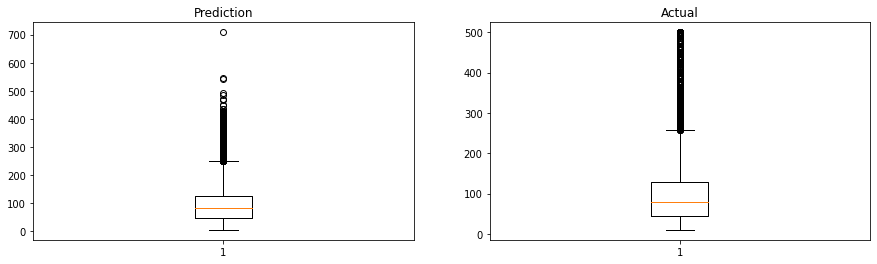

In [96]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Prediction")
plt.boxplot(prediction)
plt.subplot(1, 2, 2)
plt.title("Actual")
plt.boxplot(y_test_nlp)

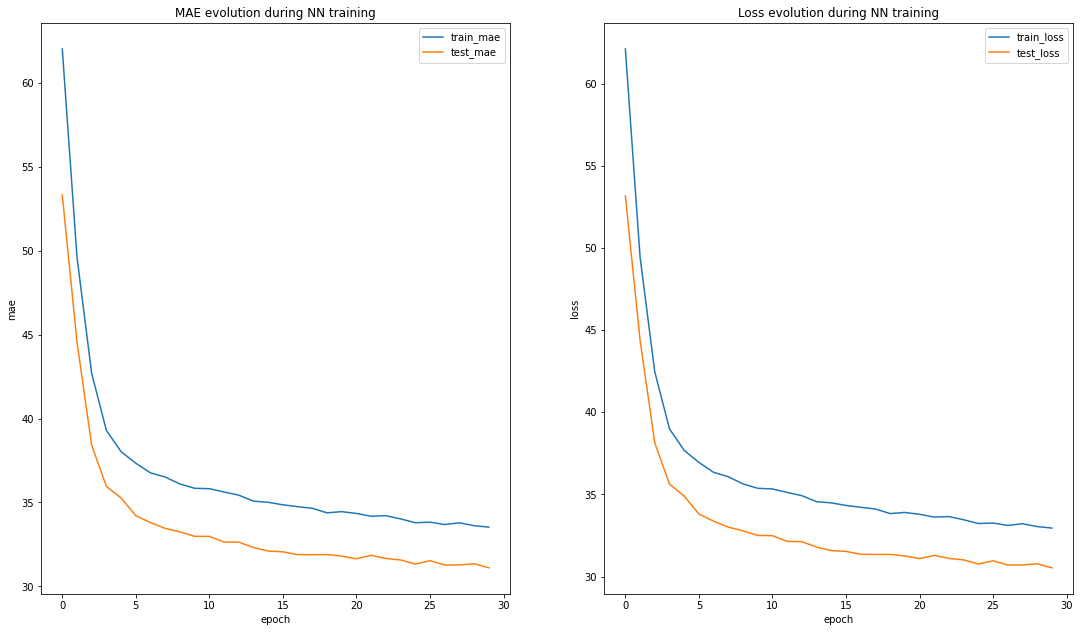

In [28]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['mae'])
    ax1.plot(story.history['val_mae'])
    ax1.set(xlabel='epoch', ylabel='mae')
    ax1.legend(['train_mae', 'test_mae'], loc='best')
    ax1.set_title('MAE evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()

show_history(history)

## 6. Comparison of word embeddings

As expected, using pre-trained embeddings will almost surely give better results than training embeddings from zero. 
It is observed that the all the Deep Learning Models perform better with pre-trained word embedddings than the self-trained embeddings using TextVectorization(see Self_trained_emb_modeling_airbnb.ipynb) in our scenario. All models using pre-trained embeddings had better MAE and also did not overfit the training severly. On the other hand, the self-embedding models overfit the data even on using highly powerful neural networks, like LSTM,Cnn-LSTM and Bidirectional LSTM.  Also pre-trained word embeddings lead to a faster training and a lower final training loss. It can be interpreted that the model could pick up more semantic signals from the pre-trained embeddings than it did from the training data through the embedding layer. Therefore, we apply the pre-trained word embedding model to our Unseen(Test) Data.

## 7. Application to Test Set

We now train our full model on the entire training data again. Therefore we will use the embeddding matrices which we obtained after re-initializing our tokenizers so they take into account the whole set of words.

In [93]:
train_num = train.select_dtypes(exclude=["category","datetime64[ns]","object"])

In [57]:
X = train_num.drop(['price'], axis=1) 
y = train_num[['price']]

In [59]:
def create_ann():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='relu'))
    # model.add(layers.Dense(1, activation='linear'))
    # model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model


rnn_units = 128

def create_w2v_text_model(max_len,NUM_WORDS,wiki_weights):
    model = models.Sequential()
    model.add(layers.Input(shape=(max_len,), dtype=tf.int32))
    model.add(layers.Embedding(input_dim=NUM_WORDS, output_dim=100, input_length=max_len,embeddings_initializer=Constant(wiki_weights),
                     trainable=False) )
    model.add(layers.Conv1D(filters=16,kernel_size=5))
    model.add(layers.AveragePooling1D(pool_size=2,strides=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(rnn_units, return_sequences=True, kernel_regularizer='l2'))
    model.add(layers.Dense(1, activation="relu"))
    return model


def create_combined_model(X):
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(128, activation="relu")(X)
    # X = layers.Dense(64, activation="relu")(X)
    X = layers.Dense(1, activation="relu")(X)
    print(X.shape)
    return X


def create_model():
    
   ### Initialize Input layers
    input_summary = tf.keras.Input(shape=(101,), dtype=tf.int32, name="summary")
    input_name = tf.keras.Input(shape=(8,), dtype=tf.int32, name="name")
    input_space = tf.keras.Input(shape=(116,), dtype=tf.int32, name="space")
    input_neighborhood_overview = tf.keras.Input(shape=(109,), dtype=tf.int32, name="neighborhood_overview")
    input_numeric = tf.keras.Input(shape=(train_num_cols.shape[1],), dtype=tf.float64, name="numeric")
    
    ### Create Vectorisation models from text features
    summary_model = create_w2v_text_model(101,NUM_WORDS_SUMMARY,wiki_weights_summary)
    name_model = create_w2v_text_model(8,NUM_WORDS_NAME,wiki_weights_name)
    space_model = create_w2v_text_model(116,NUM_WORDS_SPACE,wiki_weights_space)
    neighborhood_overview_model = create_w2v_text_model(109,NUM_WORDS_NGBR,wiki_weights_ngbr)

    ### Create Data flow
    emb_summary = summary_model(input_summary)
    emb_name = name_model(input_name)
    emb_space = space_model(input_space)
    emb_neighborhood_overview = neighborhood_overview_model(input_neighborhood_overview)
    numeric_layers = create_ann()(input_numeric)

    concat_combined = layers.Concatenate(axis=1)([
                                                    emb_summary,
                                                    emb_name,
                                                    emb_space,
                                                    emb_neighborhood_overview
                                                    ])
    print(concat_combined.shape)
    concat_combined = layers.Flatten()(concat_combined)
    concat_combined = layers.Concatenate()([concat_combined, numeric_layers])
    output = create_combined_model(concat_combined)
    
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [
                                    input_summary, 
                                    input_name, 
                                    input_space, 
                                    input_neighborhood_overview,
                                    input_numeric
                                    ], 
                            outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                loss=losses.LogCosh(), metrics=['mae'])
    return model

model = create_model()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, verbose=0, patience=3, restore_best_weights=True)

history = model.fit(
    {
        "summary" : tf.convert_to_tensor(tr_summary), 
        "name" : tf.convert_to_tensor(tr_name),
        "space" : tf.convert_to_tensor(tr_space),
        "neighborhood_overview" : tf.convert_to_tensor(tr_ngbr),
        "numeric" : tf.convert_to_tensor(X)
    },
    tf.convert_to_tensor(y.values),
    validation_split=0.2,
    epochs = 30,
    batch_size = 64,
    callbacks = [earlystopping],
    verbose =1)

(None, 158, 1)
(None, 1)
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 101)]        0                                            
__________________________________________________________________________________________________
name (InputLayer)               [(None, 8)]          0                                            
__________________________________________________________________________________________________
space (InputLayer)              [(None, 116)]        0                                            
__________________________________________________________________________________________________
neighborhood_overview (InputLay [(None, 109)]        0                                            
__________________________________________________________________

In [72]:
final_composite_predictions = pd.DataFrame(model.predict([test_summary,test_name,test_space,test_ngbr, test_num_cols]), columns=["price"], index=test.listing_id)
final_composite_predictions

,price
listing_id,
0FEMC4VA5U,89.851578
PQ2BYEO0QR,115.335762
3FP6WFHUBN,46.525352
GG0V2KDG90,43.038242
TZVVK4YSIO,91.290749
...,...
SCRJ69GZPK,254.935471
ILZN192SUC,45.317337
A44OQ7GPYY,174.624405


In [74]:
final_composite_predictions.to_csv("submission.csv")

# Conclusion

This project majorily focuses on Natural Language Processing and the data set was an apt representation of the industrial data. We were able to harness the predictive power of textual data, propotionally comparable to the non-text data. 
The pre-trained word embeddings proved to outshone the pre-training of our own word embedddings, as is seen in the real world. The integration of text and non-text columns in the NLP pipeline gave the best results in the RNN architecture for both the labeled and unseen dataset. 

Although, potential improvements can be made to model by incorporating the image feature and review dataset. Addtionally,  data cleaning could be done even more thoroughly, since we are sure that there still exist anomalities in the text features. On the other hand, it would probably never be possible to fully clean this data set.

Furthermore, a even more advanced and complex model architecture can be implemented which might prove to improve the overall model performance for instance transformer networks. However, we were able to strike a balance between model complexity and model performance through CNN-LSTMs. 